# Cosine similarity between sentence vectors as a noisy label source

At sentence level. Various `sentence-bert` models are available at https://www.sbert.net/docs/pretrained_models.html

We try representations trained for different tasks: 

* **asymmetric semantic search**, where a short query is provided to try to retrieve a longer paragraph
* **symmetric semantic search**, where a query is provided to try to retrieve a similar-sized phrase

## KD notes

- it seems that symmetric is more effective than asymmetric
- the symmetric model also seems to do a good job at *not* assigning a sentence an sectorument/sector label when there is no relevant instrument/sector
- I've left the thresholds intentionally low in the notebook so we can have a look at some False Negatives
- it was much more effective to generate keyword vectors using `{KEYWORD} {SUBSECTOR}` rather than just keyword, due to some keywords being not so topic-specific

In [2]:
!pip install sentence-transformers umap-learn seaborn "numpy<1.20"

  Using cached umap_learn-0.5.1-py3-none-any.whl
  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Using cached numpy-1.19.5-cp38-cp38-macosx_10_9_x86_64.whl (15.6 MB)
  Using cached pynndescent-0.5.4-py3-none-any.whl
     |████████████████████████████████| 2.3 MB 14.9 MB/s eta 0:00:01
  Using cached matplotlib-3.4.3-cp38-cp38-macosx_10_9_x86_64.whl (7.2 MB)
  Using cached kiwisolver-1.3.2-cp38-cp38-macosx_10_9_x86_64.whl (61 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached llvmlite-0.37.0-cp38-cp38-macosx_10_9_x86_64.whl (19.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.2
    Uninstalling numpy-1.21.2:
      Successfully uninstalled numpy-1.21.2


In [3]:
from pathlib import Path
from typing import List, Callable
import math
import pickle

from sentence_transformers import SentenceTransformer
from sentence_transformers import util as sbert_utils
from tqdm.auto import tqdm
import pandas as pd
#import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import boto3

from utils import Schema, load_policy_dataset, CosineDistanceClassifier

NameError: name 'torch' is not defined

In [73]:
s3_url = 's3://cpr-policy-bucket/'
dataset_filename = 'policy_dataset.csv.gz'

In [74]:
s3_dataset_path = s3_url + dataset_filename
df = pd.read_csv(s3_dataset_path) #load_policy_dataset()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1666918 entries, 0 to 1666917
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   Unnamed: 0   1666918 non-null  int64 
 1   policy_id    1666918 non-null  int64 
 2   policy_name  1666918 non-null  object
 3   page_id      1666918 non-null  int64 
 4   text         1666918 non-null  object
dtypes: int64(3), object(2)
memory usage: 63.6+ MB


In [75]:
# Add unique id for each text entry
df['text_id'] = range(0, len(df))

### Filter dataset by length

In [76]:
text_word_count = df.text.apply(lambda t: len(t.split(' ')))

In [77]:
text_length = df.text.str.len()

In [78]:
print(text_length.mean(), text_word_count.mean())

143.79738835383625 21.963154756262757


<AxesSubplot:>

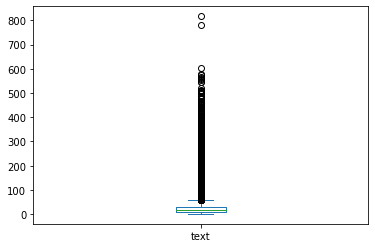

In [79]:
text_word_count.plot.box()

In [80]:
cum_word_length_count = 0
for word_length in range(1, 10):
    word_length_count = (text_word_count < word_length).sum()
    cum_word_length_count += word_length_count
    cum_frac = cum_word_length_count / len(df)

    print(f'word length = {word_length}: ', word_length_count, cum_word_length_count, cum_frac)

word length = 1:  0 0 0.0
word length = 2:  64 64 3.839421015310891e-05
word length = 3:  58830 58894 0.03533107207433119
word length = 4:  110695 169589 0.10173805790086855
word length = 5:  165901 335490 0.2012636494416642
word length = 6:  215331 550821 0.33044276923040006
word length = 7:  266412 817233 0.4902658679071196
word length = 8:  314325 1131558 0.6788324320692439
word length = 9:  362458 1494016 0.8962744418141744


In [81]:
df.loc[text_word_count == 5, 'text'].sample(20)

905913                6.13 Monitoring and Evaluation (MandE)
334426                        4.6.12 Aichi Target 12: 4.6.13
185257       Source: International Finance Statistics (IFS).
1640455                     MUST be removed before printing.
874525                         Likely this century (to 2100)
237953                       30 Annex 2 Climate Science.-38.
1496023                     The EEG is extremely successful.
1294930               Lake District National Park Authority.
7880                           26 TARGETS AND POLICY SHIFTS.
922736                                    55 As of May 2017.
213904                              51 5.2 Legal Framework .
968520                            The objectives are to: 79.
931460               Prioritisation of adaptation options 4.
1344737                       5 CEEP Grant Guidelines, p.45.
1222063    publications-2/roadmap-to-zero/ Better Buildin...
955138                    Tuvalu National Energy Policy 2009
668573                 y

We will filter out any text passages of less than 5 words. There are quite a significant number of them (10% of the total corpus). Looking at examples of 4 words or less, they tend to be titles or partially extracted passages.

In [82]:
df = df.loc[text_word_count >= 4, :]

In [83]:
len(df)

1556223

In [84]:
df.sample(5)

,Unnamed: 0,policy_id,policy_name,page_id,text,text_id
226251,226251,198,Decree-Law No. 01/2013 establishing the struct...,23,Documentos que integrem a deciso ou deliberao ...,226251
630633,630633,540,The 12th National Economic and Social Developm...,208,fast-changing technology: by promoting researc...,630633
602184,602184,523,Infrastructure Act 2015,120,Infrastructure Act 2015 (c. 7) SCHEDULE 6 Comm...,602184
1289149,1289149,1137,National renewable energy action plan 2013 Alb...,158,"Collaborazione Tra Comune, Regione ed Enel Gre...",1289149
1181404,1181404,1035,Three Year Action Agenda India (2017),101,"India Transport Report: Moving India to 2032, ...",1181404


### Load instrument and sector schemas

In [15]:
SCHEMA_FOLDER = Path("../../schema")

instruments = Schema.from_yaml_path(SCHEMA_FOLDER/"instruments.yml")
sectors = Schema.from_yaml_path(SCHEMA_FOLDER/"sectors.yml")

## 1. Different model types

In [37]:
def plot_projections(emb_2d: np.ndarray, schema: Schema, start_end: List[int] = None):
    twod_df = pd.DataFrame(emb_2d, columns=["x", "y"])
    twod_df['keyword'] = schema.all_keywords
    twod_df['subsector'] = twod_df['keyword'].map(schema.keyword_subsector_mapping)
    
    if start_end:
        twod_df = twod_df.sort_values('subsector', ascending=True).iloc[start_end[0], start_end[1]]

    _, ax = plt.subplots(figsize=(20,15))
    sns.scatterplot(x=twod_df["x"], y=twod_df["y"], hue=twod_df["subsector"], markers=".")

# plotting the projections doesn't seem to expose any particularly useful structure but the code is here just in case!
# reducer = umap.UMAP()
# sector_keyword_embeddings_2d = reducer.fit_transform(sector_keyword_embeddings)

# plot_projections(sector_keyword_embeddings_2d, sectors)


In [28]:
clf_instruments_asymm_cosine.encoder.device

device(type='cuda', index=0)

### 1a) Asymmetric semantic search

In [33]:
"""
Model choices (from https://www.sbert.net/docs/pretrained-models/msmarco-v3.html):
- msmarco-MiniLM-L-6-v3: tuned for cosine similarity, which prefers retrieving shorter passages
- msmarco-distilbert-base-v4: same, but larger
- msmarco-distilbert-base-tas-b: tuned for dot product, which prefers retrieval of longer passages
"""

clf_instruments_asymm_cosine = CosineDistanceClassifier(
    schema = instruments, 
    sbert_model = "msmarco-MiniLM-L-6-v3", 
    distance_measure= "cosine",
    concat_keywords_with_subsectors= True,
)

clf_sectors_asymm_cosine = CosineDistanceClassifier(
    schema = sectors, 
    sbert_model = "msmarco-MiniLM-L-6-v3", 
    distance_measure= "cosine",
    concat_keywords_with_subsectors= True,
)


In [18]:
import torch

In [19]:
torch.cuda.is_available()

True

### Batched predictions

In [58]:
def total_batches(text_arr, batch_size):
    n = len(text_arr)
    batch_total = math.ceil(n / batch_size)
    
    return batch_total

In [59]:
def get_batches(text_arr, batch_size):
    n = len(text_arr)
    batch_total_idx = math.ceil(n / batch_size) * batch_size
    for batch_idx in range(0, batch_total_idx, batch_size):
        yield text_arr[batch_idx:batch_idx + batch_size]
#def get_batches(n, batch_size):


In [21]:
def save_embeddings(batches_query_emb, save_path: Path):
    """Save query embeddings"""

    emb = torch.cat(batches_query_emb)

    with open(save_path, 'wb') as embedding_f:
        pickle.dump(emb, embedding_f, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
def normalise_predictions(b_df, preds, conf, schema):
    b_preds = []
    for ix in range(len(b_df)):
        for p_ix, p in enumerate(preds[ix]):
            b_preds.append(
                {
                    'policy_id': b_df.iloc[ix]['policy_id'],
                    'page_id': b_df.iloc[ix]['page_id'],
                    'text_id': b_df.iloc[ix]['text_id'],
                    'schema': schema,
                    'pred': p,
                    'conf': conf[ix][p_ix]
                }
            )

    return pd.DataFrame(b_preds)

In [23]:
data_path = Path('../../data')
embedding_path = data_path / 'policy_text_embeddings.pkl'
predictions_path = data_path / 'policy_text_predictions.csv.gz'

In [57]:
n_batches

2000

In [87]:
if predictions_path.exists():
    predictions_path.unlink()

threshold = 0.35
save_every = 1
reset_batches = False
batch_size = 100

all_query_emb = []
all_instr_preds = []
all_instr_conf = []
all_sector_preds = []
all_sector_conf = []

predictions = []

n_batches = total_batches(df, batch_size)

for b_ix, b_df in enumerate(tqdm(get_batches(df, batch_size), total=n_batches)):
    batch_query_emb, instrument_preds, instrument_conf = clf_instruments_asymm_cosine.predict(b_df.text.values, threshold, True)
    sector_preds, sector_conf = clf_sectors_asymm_cosine.predict(b_df.text.values, threshold, False)

    predictions = pd.concat(
        [
            normalise_predictions(b_df, instrument_preds, instrument_conf, 'instrument'),
            normalise_predictions(b_df, sector_preds, sector_conf, 'sector')
        ]
    )

    all_query_emb.append(batch_query_emb)

    if b_ix % save_every == 0:
        if predictions_path.exists():
            mode = 'at'
            header = False
        else:
            mode = 'wt'
            header = True
        predictions.to_csv(predictions_path, mode=mode, header=header, index=False), 

save_embeddings(all_query_emb, embedding_path)

  0%|          | 0/15563 [00:00<?, ?it/s]

### Save predictions to s3

In [89]:
predictions_df = pd.read_csv(predictions_path, index_col=False)

In [90]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250804 entries, 0 to 4250803
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   policy_id  int64  
 1   page_id    int64  
 2   text_id    int64  
 3   schema     object 
 4   pred       object 
 5   conf       float64
dtypes: float64(1), int64(3), object(2)
memory usage: 194.6+ MB


In [91]:
predictions_df.head(20)

,policy_id,page_id,text_id,schema,pred,conf
0,0,0,0,instrument,Designing processes,0.361295
1,0,0,1,instrument,Structures and processes,0.411874
2,0,0,1,instrument,Infrastructure,0.387466
3,0,0,1,instrument,Knowledge generation,0.368524
4,0,0,2,instrument,Knowledge sharing and dissemination,0.350241
5,0,0,4,instrument,Designing processes,0.366035
6,0,0,5,instrument,Standards,0.370558
7,0,0,5,instrument,Developing plans and stratgegies,0.363585
8,0,0,5,instrument,Structures and processes,0.361285
9,0,0,8,instrument,Management and planning,0.361555


In [95]:
!ls ../../data/ -l --block-size=M

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
total 2320M
-rw-rw-r-- 1 ec2-user ec2-user 2280M Oct  8 13:45 policy_text_embeddings.pkl
-rw-rw-r-- 1 ec2-user ec2-user   41M Oct  8 13:45 policy_text_predictions.csv.gz


## Save embeddings to s3

In [ ]:
!gzip ../../data/gzip policy_text_embeddings.pkl

In [119]:
s3_client = boto3.client('s3')
s3_client.upload_file(str(predictions_path), 'cpr-datasets', 'policy_text_predictions.csv.gz')
compressed_embedding_path = str(embedding_path.parent / f'{embedding_path.stem}.pkl.gz')
s3_client.upload_file(compressed_embedding_path, 'cpr-datasets', 'policy_text_embeddings.pkl.gz')

### Example predictions (superceeded)

In [130]:
THRESHOLD = 0.35

for _str in examples:
    print(_str)
    print()
    print("INSTRUMENT PREDICTIONS")
    print("\n".join([f"- {pred}" for pred in clf_instruments_asymm_cosine.predict(_str, THRESHOLD)]))
    print()
    print("SECTOR PREDICTIONS")
    print("\n".join([f"- {pred}" for pred in clf_sectors_asymm_cosine.predict(_str, THRESHOLD)]))
    print("----------------------")

Sources of Energy Supply At present, Bangladesh has energy supply from both renewable and nonrenewable sources, 38 percent of which comes from biomass (Figure 3.1).

INSTRUMENT PREDICTIONS
- ('fossil fuel subsidy', 'Fiscal or financial incentives', 0.4097)
- ('tariff', 'Fiscal or financial incentives', 0.3522)

SECTOR PREDICTIONS
- ('fossil fuels', 'Energy production', 0.4043)
- ('fossil fuel fires', 'Energy production', 0.38)
- ('electricity subsidies', 'Energy use', 0.3708)
- ('renewable energy', 'Energy production', 0.3685)
- ('solar energy', 'Energy production', 0.362)
- ('forest tundra', 'Forestry', 0.3572)
- ('energy technology', 'Energy use', 0.3555)
----------------------
To put that in real-world context, roughly 35 jobs are created for each million board feet of wood processed.

INSTRUMENT PREDICTIONS


SECTOR PREDICTIONS

----------------------
Research on the likelihood of disasters and the assessment of the likely social, economic and environmental impacts will be conducte

### 1b) Symmetric semantic search

In [126]:
"""
Model choices (from https://www.sbert.net/docs/pretrained_models.html#semantic-search):
- multi-qa-MiniLM-L6-cos-v1: tuned for cosine similarity, which prefers retrieving shorter passages
- multi-qa-MiniLM-L6-dot-v1: tuned for dot product, which prefers retrieval of longer passages
"""

emb_symsearch = SentenceTransformer("multi-qa-MiniLM-L6-dot-v1")

clf_instruments_symm_cosine = CosineDistanceClassifier(
    schema = instruments, 
    sbert_model = "multi-qa-MiniLM-L6-cos-v1", 
    distance_measure= "cosine",
    concat_keywords_with_subsectors= True,
)

clf_sectors_symm_cosine = CosineDistanceClassifier(
    schema = sectors, 
    sbert_model = "multi-qa-MiniLM-L6-cos-v1", 
    distance_measure= "cosine",
    concat_keywords_with_subsectors= True,
)


In [128]:
THRESHOLD = 0.4

for _str in examples:
    print(_str)
    print()
    print("INSTRUMENT PREDICTIONS")
    print("\n".join([f"- {pred}" for pred in clf_instruments_symm_cosine.predict(_str, THRESHOLD)]))
    print()
    print("SECTOR PREDICTIONS")
    print("\n".join([f"- {pred}" for pred in clf_sectors_symm_cosine.predict(_str, THRESHOLD)]))
    print("----------------------")

Sources of Energy Supply At present, Bangladesh has energy supply from both renewable and nonrenewable sources, 38 percent of which comes from biomass (Figure 3.1).

INSTRUMENT PREDICTIONS


SECTOR PREDICTIONS
- ('renewables', 'Energy production', 0.4862)
- ('renewable energy', 'Energy production', 0.4853)
- ('energy demand', 'Energy production', 0.468)
- ('fossil fuels', 'Energy production', 0.4601)
- ('offshore', 'Energy production', 0.4592)
- ('onshore', 'Energy production', 0.4528)
- ('natural gas', 'Energy production', 0.4483)
- ('fossil fuel fires', 'Energy production', 0.4445)
- ('biofuels', 'Energy production', 0.4425)
- ('energy production', 'Energy production', 0.4246)
- ('energy', 'Energy (general)', 0.4242)
- ('energy industries', 'Energy production', 0.4236)
- ('fuels', 'Energy production', 0.4177)
- ('nuclear energy', 'Energy production', 0.4138)
- ('power', 'Energy use', 0.4129)
- ('gas', 'Energy production', 0.4089)
- ('energy use', 'Energy use', 0.4076)
- ('bioethanol'